# Importing Data Set

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 100)

data = pd.read_excel('default of credit card clients.xls', header=1, index_col=0)

col_names = ['Balance', 'Sex', 'Education', 'Marriage', 'Age',
            'Paid_Sep', 'Paid_Aug', 'Paid_Jul', 'Paid_Jun', 'Paid_May', 'Paid_Apr',
            'Bill_Sep', 'Bill_Aug', 'Bill_Jul', 'Bill_Jun', 'Bill_May', 'Bill_Apr',
            'PayAmt_Sep', 'PayAmt_Aug', 'PayAmt_Jul', 'PayAmt_Jun', 'PayAmt_May', 'PayAmt_Apr',
            'Default']

data.columns = col_names
data = data.astype(str).astype(int)

data.head()

,Balance,Sex,Education,Marriage,Age,Paid_Sep,Paid_Aug,Paid_Jul,Paid_Jun,Paid_May,Paid_Apr,Bill_Sep,Bill_Aug,Bill_Jul,Bill_Jun,Bill_May,Bill_Apr,PayAmt_Sep,PayAmt_Aug,PayAmt_Jul,PayAmt_Jun,PayAmt_May,PayAmt_Apr,Default
ID,,,,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


# Splitting and Scaling Data

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Step 1: Label response and predictors
response =['Default']
predictors = [x for x in list(data.columns) if x not in response]

# Step 2: Split data set
y = data[response].copy()
X = data[predictors].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Step 3: Prepare for scaling
#scaler = StandardScaler().fit(X_train)
#
## Step 4: Scale the data
#X_train = scaler.transform(X_train)
#X_test = scaler.transform(X_test)

Note that scaling has been temporarily commented out as the baseline model actually doesn't perform better when using l1 penalty, as we are specifying below)

However, for l2 penalty, scaling leads to the results we get from l1 penalty without scaling. This makes sense, as l2 (ridge) works "better when predictors are of similar magnitude" (QBUS3820), which is not the case here.

Further, **not scaling the data is necessary** for the tweaks that are undertaken below for dealing with the class imbalance.

# Baseline Model

In [3]:
import numpy as np
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(penalty='l1')
logit.fit(X_train, np.ravel(y_train))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [5]:
# Score against test set
accuracy = logit.score(X_test, np.ravel(y_test))
print('Accuracy:', accuracy.round(3))

Accuracy: 0.81


In [7]:
# AUC calculation
from sklearn.metrics import roc_auc_score
y_score = logit.fit(X_train, np.ravel(y_train)).decision_function(X_test)

roc_auc = roc_auc_score(y_test, y_score)
print('AUC:', roc_auc.round(3))

AUC: 0.727


In [8]:
# ALTERNATIVE AUC calculation
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc.round(3))

AUC: 0.727


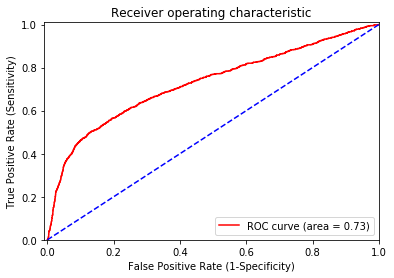

In [9]:
# ROC curve
import matplotlib.pyplot as plt

plt.figure()

plt.plot(fpr, tpr, color='red',
         label='ROC curve (area = {})'.format(roc_auc.round(2)))

plt.plot([0, 1], [0, 1], color='blue', linestyle='--')

plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])

plt.xlabel('False Positive Rate (1-Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

plt.show()

Recall that we want to maximise the AUC

### Confusion matrix

In [10]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
y_pred = logit.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion matrix:\n', cnf_matrix)

Confusion matrix:
 [[4549  138]
 [1002  311]]


In [11]:
import itertools

# Based off http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Truth')
    plt.xlabel('Predicted')
    plt.tight_layout()

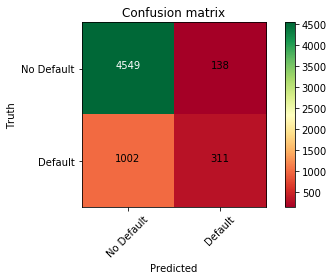

In [12]:
class_names = ['No Default','Default']

plot_confusion_matrix(cnf_matrix, classes=class_names, cmap=plt.cm.RdYlGn,
                      title='Confusion matrix')
plt.show()

Note the order from top to bottom, left to right: TP: 4549 | FN: 138 | FP: 1003 | TN: 310





In [13]:
# Some metrics
total = sum(sum(cnf_matrix))

accuracy = (cnf_matrix[0,0]+cnf_matrix[1,1])/total
sensitivity = cnf_matrix[0,0]/(cnf_matrix[0,0]+cnf_matrix[0,1])
precision = cnf_matrix[0,0]/(cnf_matrix[0,0]+cnf_matrix[1,1])
specificity = cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])

print('Accuracy:', accuracy.round(3))
print('Sensitivity (Recall):', sensitivity.round(3))
print('Precision:', precision.round(3))
print('Specificity:', specificity.round(3))

Accuracy: 0.81
Sensitivity (Recall): 0.971
Precision: 0.936
Specificity: 0.237


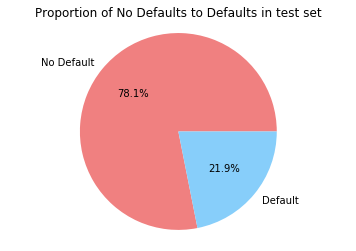

In [15]:
test_class_ratio = y_test['Default'].value_counts()

labels = 'No Default', 'Default'
sizes = [test_class_ratio[0], test_class_ratio[1]]
colors = ['lightcoral', 'lightskyblue']
 
plt.pie(sizes, labels=labels, colors=colors,
        autopct='%.1f%%')
 
plt.axis('equal')
plt.title('Proportion of No Defaults to Defaults in test set')

plt.show()

Basically, we aren't doing much better than guessing... 0.81 to 0.78 (with scaling), without we essentially perform at the theoretical minimum majority class rate (unless we use l1 penalty, then we get the same as scaling basically)

### Dealing with imbalanced classes

In [16]:
train = X_train.join(y_train)
train_majority = train[train['Default']==0]
train_minority = train[train['Default']==1]

Rejoining the split X and y from test_train_split earlier, and then splitting up based on classes

In [17]:
n_majority = train_majority['Default'].count()
n_minority = train_minority['Default'].count()

print('No Defaults:', n_majority)
print('Defaults:', n_minority)

No Defaults: 18677
Defaults: 5323


Clearly, at least in the train set that we split, there are significnatly fewer Default reponses -- this is a class imbalance problem that we must deal with (either via **upsampling the defaults**, or **downsamping the no defaults**)

**Upsampling**: may lead to overfitting due to replications of the minority class, whereas;

**Downsampling**: may lead to bias due to discarding potentially useful info

A third, alternative method we can use is called SMOTE (synthetic minority over-sampling technique) -- link for more info: http://rikunert.com/SMOTE_explained

In [18]:
from sklearn.utils import resample

# Downsampling majority class
train_majority_down = resample(train_majority, replace=False, n_samples=n_minority, random_state=42)
train_down = pd.concat([train_minority, train_majority_down])
X_down = train_down[predictors].copy()
y_down = train_down[response].copy()

# Upsampling minority class
train_minority_up = resample(train_minority, replace=True, n_samples=n_majority, random_state=42)
train_up = pd.concat([train_majority, train_minority_up])
X_up = train_up[predictors].copy()
y_up = train_up[response].copy()

In the first cell, we are downsampling the majority class (no defaults) by essentially resampling without replacement. This allow us to build a new dataset essentially,  only up to the same number of samples as the minority class (5323)

In the second cell, we are upsampling the minority class (defaults) by resampling with replacement, up to the same number of samples as no defaults (18677)

In [19]:
#conda install -c glemaitre imbalanced-learn
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42, ratio='auto')
X_SMOTE, y_SMOTE = sm.fit_sample(X_train, np.ravel(y_train))

This method uses the SMOTE algorithm as highlighted above. Note that there are many parameters that I've left as default, for simplicty now - but some things to explore are the k neighbours and SVM.

### Running baseline models with the rebalanced classes

In [20]:
%%time
logit_down = LogisticRegression(penalty='l1')
logit_down.fit(X_down, np.ravel(y_down))

Wall time: 284 ms


In [21]:
%%time
logit_up = LogisticRegression(penalty='l1')
logit_up.fit(X_up, np.ravel(y_up))

Wall time: 1.12 s


_Note: this took noticably longer to run, due to the upsizing_

In [22]:
%%time
logit_SMOTE = LogisticRegression(penalty='l1')
logit_SMOTE.fit(X_SMOTE, np.ravel(y_SMOTE))

Wall time: 1.11 s


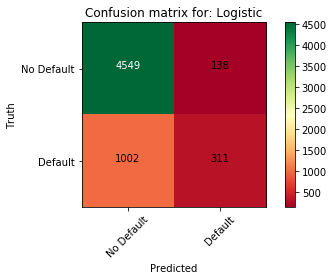

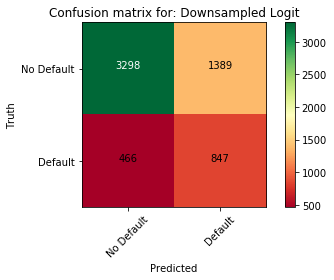

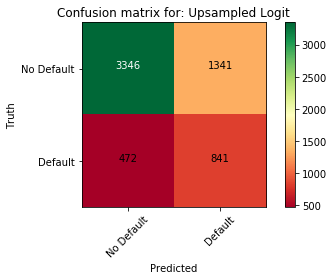

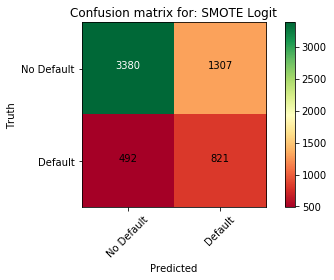

,Accuracy,AUC,Sensitivity,Specificity
Logistic,0.810000,0.727031,0.970557,0.236862
Downsampled Logit,0.690833,0.729420,0.703648,0.645088
Upsampled Logit,0.697833,0.727533,0.713889,0.640518
SMOTE Logit,0.700167,0.728910,0.721144,0.625286


In [23]:
# Evaluation of baseline with rebalanced classes
col = ['Accuracy', 'AUC', 'Sensitivity', 'Specificity']
row = ['Logistic', 'Downsampled Logit', 'Upsampled Logit', 'SMOTE Logit']
models = [logit, logit_down, logit_up, logit_SMOTE]

data = [[X_train, y_train],
        [X_up, y_up],
        [X_down, y_down],
        [X_SMOTE, y_SMOTE]]

results = pd.DataFrame(0.0, columns=col, index=row)
plt.figure()
n=0
for i in models:
    y_score = i.fit(data[n][0], np.ravel(data[n][1])).decision_function(X_test) # Calculates the score used for the AUC below
   
    y_pred = i.predict(X_test)
    cnf_matrix = confusion_matrix(y_test, y_pred)
    
    results.iloc[n,0] = i.score(X_test, y_test)
    results.iloc[n,1] = roc_auc_score(y_test, y_score)    
    results.iloc[n,2] = cnf_matrix[0,0]/(cnf_matrix[0,0]+cnf_matrix[0,1])
    results.iloc[n,3] = cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])
        
    class_names = ['No Default','Default']
    plot_confusion_matrix(cnf_matrix, classes=class_names, cmap=plt.cm.RdYlGn,
                      title='Confusion matrix for: '+str(row[n]))
    plt.show()
    
    n+=1
    
results

We see no improvements in the accuracy, however AUC remains constant, and we have dramatically increased Specificity (True Negatives - correct detection of defaults) relative to the trade-off we have against Sensitvity (True Positives).

This may be  useful in a business context, where the cost of NOT DETECTING a default substantially outweighs the profits from several correct detections of non-defaults (i.e. True Positives); that is, we may be able to accept this decrease in Sensitivity, to increase our Specificity.

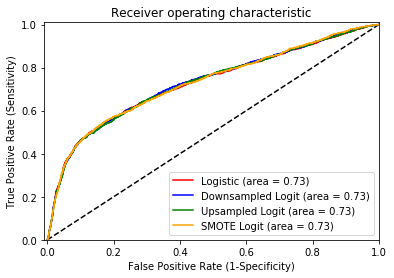

In [24]:
# ROC curves to compare
titles = ['Logistic', 'Downsampled Logit', 'Upsampled Logit', 'SMOTE Logit']
models = [logit, logit_down, logit_up, logit_SMOTE]

data = [[X_train, y_train],
        [X_up, y_up],
        [X_down, y_down],
        [X_SMOTE, y_SMOTE]]

colour = ['red','blue','green','orange']

plt.figure()
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])


n=0
for i in models:
    y_score = i.fit(data[n][0], np.ravel(data[n][1])).decision_function(X_test) # Calculates the score used for the AUC below
    
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, color=colour[n],
             label='{0} (area = {1})'.format(titles[n], roc_auc.round(2)))

    n+=1

plt.xlabel('False Positive Rate (1-Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")    
    
plt.show()

Evidently, no change in ROC curve despite changing the class balances.

### Using CV to evaluate train dataset

In [25]:
from sklearn.model_selection import cross_val_score

model = logit

score = 'roc_auc'
cross_val_score(model, X_train, np.ravel(y_train), cv=5, scoring=score)

array([0.72172354, 0.7299571 , 0.72369076, 0.71184814, 0.71758437])

In [26]:
score = 'accuracy'
cross_val_score(model, X_train, np.ravel(y_train), cv=5, scoring=score)

array([0.80566549, 0.81378879, 0.80833333, 0.81308606, 0.8091269 ])

In [27]:
score = 'f1' # This is the weighted average between precision and recall
cross_val_score(model, X_train, np.ravel(y_train), cv=5, scoring=score)

array([0.35724138, 0.36298932, 0.33597693, 0.37517434, 0.37346101])

### Hyperparameter tuning with CV

In [28]:
from sklearn.model_selection import GridSearchCV

estimator = logit
param_grid = [{'penalty': ['l1', 'l2']}]
score = 'roc_auc'

model = GridSearchCV(estimator, param_grid, scoring=score)
model.fit(X_train, np.ravel(y_train))

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'penalty': ['l1', 'l2']}], pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='roc_auc', verbose=0)

In [29]:
model.best_estimator_

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

No surprise, but l1 penalty is the best. Note that this is on the generic X_train dataset, not the rebalanced ones.

# Other methods
* LDA/QDA
* SVMs
* SGD classification
* Gaussian process classification
* Naive Bayes
* Nearest neighbours classification - **CINDY**
* Classification decision trees - **CINDY**
* Bagging - **CINDY**
* Random forest - **CINDY**
* AdaBoost - **SCOTT**
* Gradient tree boosting - **SCOTT**
* Neural nets - **SCOTT**

### LDA/QDA

In [30]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
lda.fit(X_train, np.ravel(y_train))

qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, np.ravel(y_train))

print('Accuracy:')
print('LDA', lda.score(X_test, y_test))
print('QDA', qda.score(X_test, y_test))

Accuracy:
LDA 0.809
QDA 0.5118333333333334


May need to tune parameters here... as below:

In [31]:
lda.get_params()

{'n_components': None,
 'priors': None,
 'shrinkage': None,
 'solver': 'svd',
 'store_covariance': False,
 'tol': 0.0001}

In [32]:
qda.get_params()

{'priors': None,
 'reg_param': 0.0,
 'store_covariance': False,
 'store_covariances': None,
 'tol': 0.0001}

### Support vector machines

In [40]:
%%time
from sklearn.svm import SVC
svc = SVC(random_state=42)
svc.fit(X_train, np.ravel(y_train))

Wall time: 3min 31s


In [41]:
print('Accuracy:')
print('SVC', svc.score(X_test, y_test))

Accuracy:
SVC 0.7806666666666666


This takes a lot of time... probably worth adding the argument, class_weight in the fit method due to the class imbalance. See these links:
* http://scikit-learn.org/stable/modules/svm.html#classification
* https://stats.stackexchange.com/questions/24959/a-priori-selection-of-svm-class-weights

### Stochastic gradient descent
Note: this is essentially a logistic regression or SVM (depending on the loss specification), which uses SGD learning
* http://scikit-learn.org/stable/modules/sgd.html
* http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html

In [45]:
%%time
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(loss="log", penalty="l1", max_iter=1000, random_state=42) # Using logistic reg, and l1 penalty
sgd.fit(X_train, np.ravel(y_train))

Wall time: 7.34 s


In [46]:
print('Accuracy:')
print('SGD', sgd.score(X_test, y_test))

Accuracy:
SGD 0.7706666666666667


### Gaussian process classification
http://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessClassifier.html

Based on this book: http://www.gaussianprocess.org/gpml/chapters/RW.pdf

In [ ]:
%%time
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

kernel = 1.0 * RBF(1.0)
gpc = GaussianProcessClassifier(kernel=kernel, random_state=42)
gpc.fit(X_train, np.ravel(y_train))

In [ ]:
print('Accuracy:')
print('GPC', gpc.score(X_test, y_test))

### Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB, ComplementNB

gnb = GaussianNB(priors=[0.8,0.2])
gnb.fit(X_train, np.ravel(y_train))

cnb = ComplementNB(alpha=1.0) # Alpha for smoothing
cnb.fit(X_train, np.ravel(y_train))

In [ ]:
print('Accuracy:')
print('GNB', gnb.score(X_test, y_test))
print('CNB', cnb.score(X_test, y_test))

GaussianNB: likelihood of the features is assumed to be Gaussian

ComplementNB: adaptation of the standard multinomial naive Bayes algorithm, suited for imbalanced data sets